In [1]:
import cv2
import sys
import numpy as np
from matplotlib import pyplot as plt
# from meshplot import plot, subplot, interact

img_path = 'C:/Users/mkjsy/Desktop/YM/Source Code/VSCode/GitHub/2024-AI-Semiconductor-Tech-Talent-Contest/sfm/data/nutellar2/'

img1_name = 'nutella13.jpg'
img2_name = 'nutella14.jpg'

# Load image
def load_image(img_path, img1_name, img2_name):
    img1 = cv2.imread(img_path + img1_name)
    img2 = cv2.imread(img_path + img2_name)
    img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)
    return img1, img2


# Find feature correspondence with SIFT
def SIFT(img1, img2):
    """Featrue extraction & describtion"""
    sift = cv2.xfeatures2d.SIFT_create()
    img1_kp, img1_des = sift.detectAndCompute(img1, None)
    img2_kp, img2_des = sift.detectAndCompute(img2, None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(img1_des, img2_des, k=2)
    matches_good = [m1 for m1, m2 in matches if m1.distance < 0.95*m2.distance]
    sorted_matches = sorted(matches_good, key=lambda x: x.distance)
    res = cv2.drawMatches(img1, img1_kp, img2, img2_kp, sorted_matches, img2, flags=2) 
    
    # drwa matches
    plt.figure(figsize=(15, 15))
    plt.imshow(res)
    plt.show()
    return matches_good, img1_kp, img2_kp


# Preprocessing
def Estimation_E(matches_good, img1_kp, img2_kp):
    '''Essential Matrix Estimation'''
    query_idx = [match.queryIdx for match in matches_good]
    train_idx = [match.trainIdx for match in matches_good]
    p1 = np.float32([img1_kp[ind].pt for ind in query_idx]) # 픽셀 좌표
    p2 = np.float32([img2_kp[ind].pt for ind in train_idx])

    # Find Essential Matrix and Inliers with RANSAC, Intrinsic parameter
    E, mask = cv2.findEssentialMat(p1, p2, method=cv2.RANSAC, focal=3092.8, pp=(2016, 1512), maxIters = 500, threshold=1) 
    p1 = p1[mask.ravel()==1] # left image inlier
    p2 = p2[mask.ravel()==1] # right image inlier

    return E, p1, p2


def EM_Decomposition(E, p1,p2):
    """Essential Matrix Decomposition, The four possible solutions from E"""
    CM = np.array([[]])
    # Essential matrix to camera matrix
    U, S, VT = np.linalg.svd(E, full_matrices=True)
    W = np.array([
        [0, -1, 0],
        [1, 0, 0],
        [0, 0, 1]
    ])

    # camera matrix = P'= [UWVT | +u3] or [UWVT | −u3] or [UWTVT | +u3] or [UWTVT | −u3].
    camera_matrix = np.array([
        np.column_stack((U @ W @ VT, U[:,2])),
        np.column_stack((U @ W @ VT, -U[:,2])),
        np.column_stack((U @ W.T @ VT, U[:,2])),
        np.column_stack((U @ W.T @ VT, -U[:,2]))])

    # camera pose matrix , Rt x , 3d point HOMOGENIEUOUS 
    for i in range(4): 
        tmp = camera_matrix[i]
        for j in range(len(p1)):
            a = p1[j].flatten()
            b = p2[j].flatten()
            c = np.concatenate((a, b))
            d = tmp@c.T # 3x4@4x4
            if np.any(d<0):
                break
            else:
                CM = camera_matrix[i]
    return CM


# Rescale to Homogeneous Coordinate
def rescale_point(pts1, pts2, length):
    a = [[]]
    b = [[]]
    for i in range(length):
        tmp1 = pts1[i].flatten()
        tmp1 = np.append(tmp1, 1)
        a = np.append(a, tmp1)
        tmp2 = pts2[i].flatten()
        tmp2 = np.append(tmp2, 1)
        b = np.append(b, tmp2)
    
    a = a.reshape((length),3)
    b = b.reshape((length),3)
    return a, b

# intrinsic parameter K
def initialize_CM(CameraMatrix):
    Rt0 = np.hstack((np.eye(3), np.zeros((3, 1))))
    skew = 0.0215878
    K = np.array([[3092.8, skew, 2016], [0, 3092.8, 1512], [0,0,1]])
    Rt1 = K @ CameraMatrix
    return Rt0, Rt1

# Triangulation
def LinearTriangulation(Rt0, Rt1, p1, p2):
    """Generate 3D point by implementing Triangulation"""
    A = [p1[1]*Rt0[2,:] - Rt0[1,:], # x(p 3row) - (p 1row) 
        -(p1[0]*Rt0[2,:] - Rt0[0,:]), # y(p 3row) - (p 2row) 
        p2[1]*Rt1[2,:] - Rt1[1,:], # x'(p' 3row) - (p' 1row) 
        -(p2[0]*Rt1[2,:] - Rt1[0,:])]  # y'(p' 3row) - (p' 2row)
        
    A = np.array(A).reshape((4,4))
    AA = A.T @ A 
    U, S, VT = np.linalg.svd(AA) # eigen vector
 
    return VT[3,0:3]/VT[3,3]

def make_3dpoint(p1, p2, Rt0, Rt1):
    p3ds = []
    for pt1, pt2 in zip(p1, p2):
        p3d = LinearTriangulation(Rt0, Rt1, pt1, pt2)
        p3ds.append(p3d)
    p3ds = np.array(p3ds).T
    return p3ds

def visualize_3d(p3ds):
    X = np.array([])
    Y = np.array([])
    Z = np.array([]) #120 
    X = np.concatenate((X, p3ds[0]))
    Y = np.concatenate((Y, p3ds[1]))
    Z = np.concatenate((Z, p3ds[2]))

    fig = plt.figure(figsize=(15,15))
    ax = plt.axes(projection='3d')
    ax.scatter3D(X, Y, Z, c='b', marker='o') 
    plt.show() 

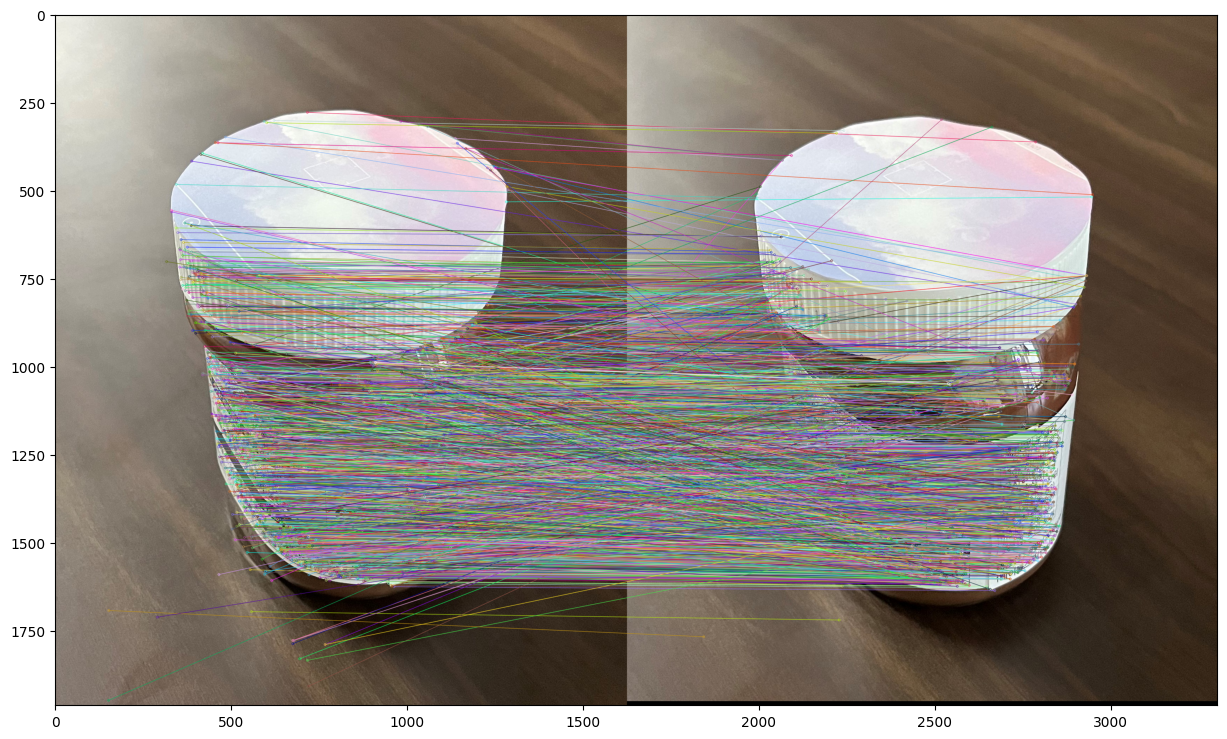

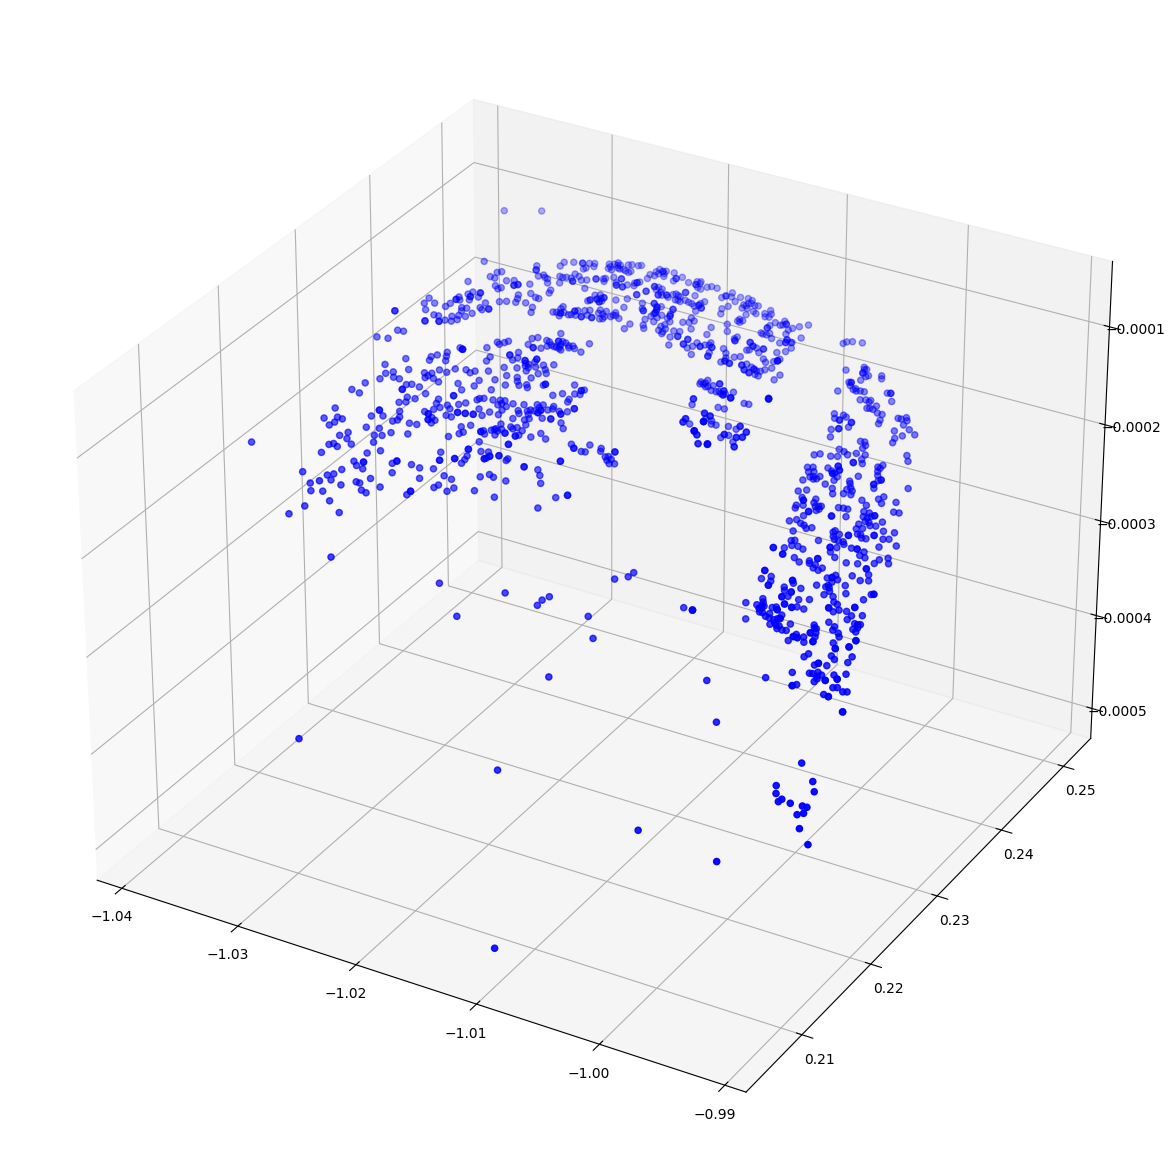

In [2]:
img1, img2 = load_image(img_path, img1_name, img2_name)
matches_good, img1_kp, img2_kp = SIFT(img1, img2)
E, p1_inlier, p2_inlier = Estimation_E(matches_good, img1_kp, img2_kp)
CameraMatrix = EM_Decomposition(E, p1_inlier, p2_inlier)
Rt0, Rt1 = initialize_CM(CameraMatrix)
p1, p2 = rescale_point(p1_inlier, p2_inlier, len(p1_inlier))
point3d = make_3dpoint(p1, p2, Rt0, Rt1)

visualize_3d(point3d)